In [1]:
#Loads in necessary packages
import numpy as np
import matplotlib.cm as cm
import numpy.random as npr
import matplotlib.pyplot as plt
import emcee
from scipy import integrate

## Single well

In [2]:
# The potential
def U(x):
    return x**2

# dU/dx
def gradU(x):
    return 2*x

## Standard Langevin

In [3]:
# Note that beta = 1 in this example

h = 0.01 # Step size of the discretization
gamma = 1 # Friction parameter
num_steps = 3000000 

npr.seed(2)

# These matrices will be filled with the samples
xsamples = np.zeros(num_steps)
psamples = np.zeros(num_steps)

# Initialize values 
x = 0.1
p = npr.randn(1) #Create auxiliary momentum variable as sample of a N(0,1) distribution

print("Starting...")
for steps in range(1,num_steps): 
    # Use BAOAB
    p -= (h/2.0)*gradU(x)  # B-step: Update Momentum Variables with half a time-step
    x += (h/2.0)*p         # A-step
      
    eta = npr.randn(1)
    p = np.exp(-gamma*h)*p +np.sqrt(1-np.exp(-2*gamma*h))*eta   # O-step

    x += (h/2.0)*p 
    p -= (h/2.0)*gradU(x)  
    
    # Store values
    xsamples[steps] = x  
    psamples[steps] = p
    
    # Print progress
    if steps % 200000 == 0:
        print('<x^2> = ',np.round(np.mean( xsamples**2),4), " at step ", steps,"/",num_steps, ", exact value of <x^2> = ", 0.5)

print("final step")
print('<x^2>',np.round(np.mean( xsamples**2),4), "exact value of <x^2> = ", 0.5)
xtest = np.linspace(-5,5,1000)
print('using composite trapezoidal rule <x^2>',np.trapz((xtest**2)*np.exp(-U(xtest)),xtest)/np.trapz(np.exp(-U(xtest)),xtest))

Starting...
<x^2> =  0.0327  at step  200000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.0675  at step  400000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.1027  at step  600000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.1397  at step  800000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.1727  at step  1000000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.2042  at step  1200000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.2378  at step  1400000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.2721  at step  1600000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.3076  at step  1800000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.3418  at step  2000000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.3747  at step  2200000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.411  at step  2400000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.445  at step  2600000 / 3000000 , exact value of <x^2> =  0.5
<x^2> =  0.4797  at step  280000

(array([3.73000e+02, 7.40300e+03, 7.02610e+04, 3.58475e+05, 8.68508e+05,
        9.87918e+05, 5.36232e+05, 1.48972e+05, 2.06440e+04, 1.21400e+03]),
 array([-3.2813696 , -2.65044216, -2.01951473, -1.38858729, -0.75765985,
        -0.12673241,  0.50419503,  1.13512247,  1.7660499 ,  2.39697734,
         3.02790478]),
 <a list of 10 Patch objects>)

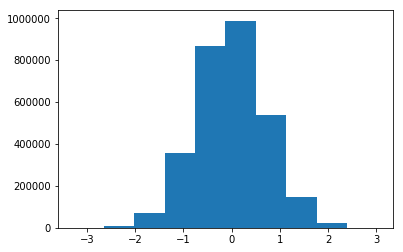

In [4]:
plt.hist(xsamples) # Should look approximately Gaussian

/Users/tiffany/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[]

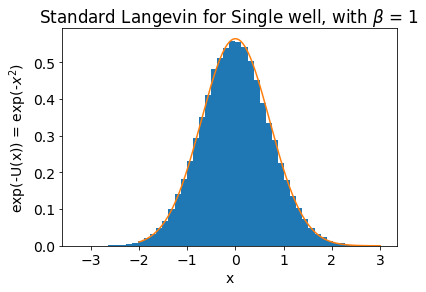

In [5]:
x_plot = np.linspace(-2,3,1000)
plt.rcParams.update({'font.size': 14})
plt.hist(xsamples,label = "hist",bins=50,normed = True)
plt.plot(x_plot,np.exp(-U(x_plot))/np.sqrt(2*np.pi*0.5))  # beta = 1
plt.ylabel("exp(-U(x)) = exp(-$x^2$)")
plt.xlabel("x")
plt.title("Standard Langevin for Single well, with $\\beta$ = 1")
#plt.legend()
plt.plot()

## ISST with force rescaling

\begin{align}
    \rho(q,p,\beta_R) &= C^{-1}(\beta)\omega(\beta_c)e^{-\frac{1}{2}\beta p^T m^{-1}p - \beta_c U(q)} \\
    &= C^{-1}(\beta)\omega(\beta_c)e^{-\frac{1}{2}\beta p^T m^{-1}p - \beta_c q^2} 
\end{align}

In [6]:
h = 0.005 # Step size of the discretization
gamma = 1 # Friction parameter
num_steps = 2000000

npr.seed(2)

# Parameters for ISST method
tau = 1  # Indicates how often we update the weights relative to the x and p parameters
M = 5   # Number of temperature values
beta_min = 0.4  #  the tempering parameter beta_c is in the interval [beta_min,beta_max]
beta_max = 1.05  # Target temperature, the tempering parameter beta_c is in the interval [beta_min,beta_max]
betatot = 1  # Physical temperature (is fixed)

# These matrices will be filled with the samples
xsamples = np.zeros(num_steps)
psamples = np.zeros(num_steps)
ObsWeights = np.zeros((num_steps,M))
weightedx2 = np.zeros((num_steps,M))

# Initialize values
x = 0.1
p = npr.randn(1) #Create auxiliary momentum variable as sample of a N(0,1) distribution

# Create temperature grid for Gauss-Legendre quadrature 
beta, B = np.polynomial.legendre.leggauss(M)  # beta are the sample points and B are the weights
betasc = 0.5*(beta + 1)*(beta_max - beta_min) + beta_min # rescale so that the sample points are in the interval [beta_min,beta_max]  (because np.polynomial.legendre.leggauss generates points in interval [-1,1])
omega = np.ones(M) # initialize the temperature weights

# # Normalize betasc   # not sure if this is necessary
# norm = np.sum(B*omega)
# betasc = betasc/norm
print('Tempering inverse temperatures beta_c =',np.round(betasc,3))

# Compute initial value of the averaged beta using eq (61) and (58) in ISST paper
z = np.exp(-betasc*U(x))/np.sum(B*omega*np.exp(-betasc*U(x)))
avgbeta = np.sum(betasc*B*omega*np.exp(-betasc*U(x)))/np.sum(B*omega*np.exp(-betasc*U(x)))

print("Starting...")
for steps in range(1,num_steps): 
    # 2nd order 'BAOAB' scheme, eq (57) in ISST paper
    p -= (h/2.0)*(1./betatot)*avgbeta*gradU(x)  
    x += (h/2.0)*p
      
    eta = npr.randn(1)
    p = np.exp(-gamma*h)*p +np.sqrt((1/betatot)*(1-np.exp(-2*gamma*h)))*eta

    x += (h/2.0)*p 
    
    # Update temperature weights and avgbeta to update the force rescaling
    # Use eq (58),(59), (60) and (63) in ISST paper
    z = ((1.0/steps)*np.exp(-betasc*U(x))/np.sum(B*omega*np.exp(-betasc*U(x))))+((steps-1)/steps)*z
    omegastar = (1-(h/tau))*omega+(h/(tau*z))
    omega = omegastar/np.sum(B*omegastar)
    avgbeta = np.sum(betasc*B*omega*np.exp(-betasc*U(x)))/np.sum(B*omega*np.exp(-betasc*U(x)))
        
    p -= (h/2.0)*(1./betatot)*avgbeta*gradU(x)  
    
    # Store the samples
    xsamples[steps] = x
    psamples[steps] = p
    
    # Compute the observable weights following eq. (29) in ISST paper

    weightobs = np.zeros(M)
    for i in range(M):
        integral = 0
        for j in range(M):
            integral += B[j]*omega[j]*np.exp(-(betasc[j] - betasc[i])*U(x))
                         
        weightobs[i] = 1/(integral*z[i])
            
    ObsWeights[steps,:] = weightobs
    
    # Compute weighted <x^2>
    weightedx2[steps,:] = weightobs*xsamples[steps]**2
    
    # Print progress
    if steps % 200000 == 0:
        print("currently at step ", steps,"/",num_steps)
        for i in range(M):
            print("<x^2> = ",np.round(np.mean(weightedx2[0:steps,i]),4)," for beta_c = ", np.round(betasc[i],3), "exact value <x^2> = ", np.round(0.5*(1/betasc[i]),3))

print("final step")
for i in range(M):
    print("<x^2> = ",np.round(np.mean(weightedx2[:,i]),4)," for beta_c = ", np.round(betasc[i],3), "exact value <x^2> = ", np.round(0.5*(1/betasc[i]),3))

Tempering inverse temperatures beta_c = [0.43  0.55  0.725 0.9   1.02 ]
Starting...
currently at step  200000 / 2000000
<x^2> =  1.1477  for beta_c =  0.43 exact value <x^2> =  1.161
<x^2> =  0.9079  for beta_c =  0.55 exact value <x^2> =  0.909
<x^2> =  0.6914  for beta_c =  0.725 exact value <x^2> =  0.69
<x^2> =  0.5582  for beta_c =  0.9 exact value <x^2> =  0.556
<x^2> =  0.4934  for beta_c =  1.02 exact value <x^2> =  0.49
currently at step  400000 / 2000000
<x^2> =  1.1997  for beta_c =  0.43 exact value <x^2> =  1.161
<x^2> =  0.9417  for beta_c =  0.55 exact value <x^2> =  0.909
<x^2> =  0.7112  for beta_c =  0.725 exact value <x^2> =  0.69
<x^2> =  0.5704  for beta_c =  0.9 exact value <x^2> =  0.556
<x^2> =  0.5024  for beta_c =  1.02 exact value <x^2> =  0.49
currently at step  600000 / 2000000
<x^2> =  1.1577  for beta_c =  0.43 exact value <x^2> =  1.161
<x^2> =  0.9121  for beta_c =  0.55 exact value <x^2> =  0.909
<x^2> =  0.6926  for beta_c =  0.725 exact value <x^2> =

In [7]:
print("Autocorrelation time = ", emcee.autocorr.integrated_time(xsamples))

Autocorrelation time =  337.4215539531474


/Users/tiffany/anaconda3/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


(array([  1776.,  16054.,  83583., 290438., 585939., 601334., 312589.,
         88146.,  18131.,   2010.]),
 array([-3.50283954, -2.80755649, -2.11227345, -1.4169904 , -0.72170736,
        -0.02642431,  0.66885873,  1.36414178,  2.05942482,  2.75470787,
         3.44999092]),
 <a list of 10 Patch objects>)

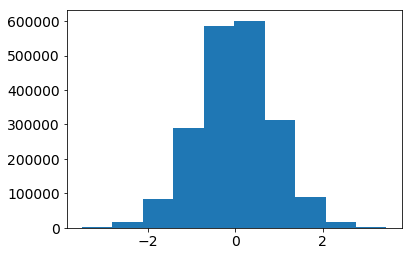

In [8]:
plt.hist(xsamples) # Should look approximately Gaussian

/Users/tiffany/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[]

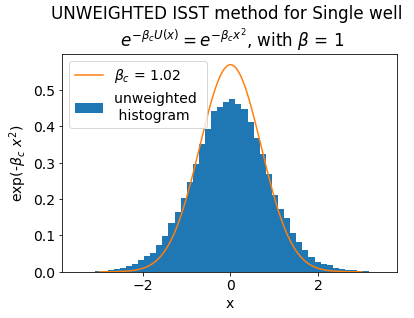

In [9]:
# Use composite trapezoidal rule to compute the normalization constant
x_integration = np.linspace(-10,10,10000)
normalization = np.trapz(np.exp(-betasc[M-1]*U(x_integration)),x_integration)

x_plot = np.linspace(-3,3,1000)
plt.rcParams.update({'font.size': 14})
plt.hist(xsamples,bins=50,normed = True, label = "unweighted \n histogram")
plt.plot(x_plot,np.exp(-betasc[M-1]*U(x_plot))/normalization,label = '$\\beta_c$ = %g' % np.round(betasc[M-1],3))  # beta = 1
plt.ylabel('exp(-$\\beta_c \ x^2$)')
plt.xlabel("x")
plt.title("UNWEIGHTED ISST method for Single well \n $e^{-\\beta_c U(x)} = e^{-\\beta_c x^2}$, with $\\beta$ = 1")
plt.legend()
plt.plot()

/Users/tiffany/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[]

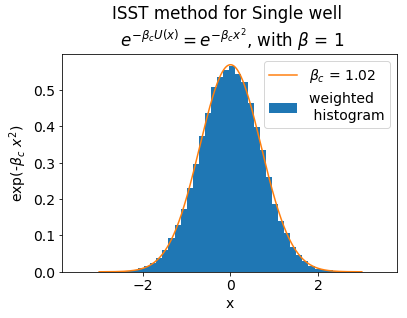

In [11]:
# Use composite trapezoidal rule to compute the normalization constant
x_integration = np.linspace(-10,10,10000)
normalization = np.trapz(np.exp(-betasc[M-1]*U(x_integration)),x_integration)

x_plot = np.linspace(-3,3,1000)
plt.rcParams.update({'font.size': 14})
plt.hist(xsamples,bins=50,normed = True, weights = ObsWeights[:,M-1], label = "weighted \n histogram")
plt.plot(x_plot,np.exp(-betasc[M-1]*U(x_plot))/normalization,label = '$\\beta_c$ = %g' % np.round(betasc[M-1],3))  # beta = 1
plt.ylabel('exp(-$\\beta_c \ x^2$)')
plt.xlabel("x")
plt.title("ISST method for Single well \n $e^{-\\beta_c U(x)} = e^{-\\beta_c x^2}$, with $\\beta$ = 1")
plt.legend()
plt.plot()

## Double-well potential

In [12]:
def U(x):    
    return x**2*(x-2)**2

def gradU(x):
    return 2*x*(x-2)**2+x**2*2*(x-2)

[]

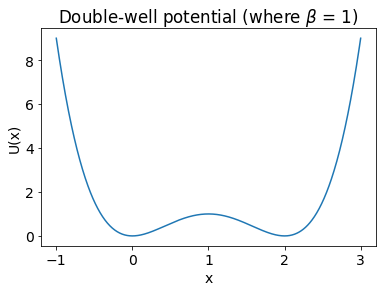

In [13]:
x_plot = np.linspace(-1,3,1000)
plt.rcParams.update({'font.size': 14})
plt.plot(x_plot,U(x_plot))
plt.ylabel("U(x)")
plt.xlabel("x")
plt.title("Double-well potential (where $\\beta$ = 1)")
plt.plot()

## Standard Langevin

In [14]:
# Note that beta = 1 in this example

h = 0.01 # Step size of the discretization
gamma = 1 # Friction parameter
num_steps = 5000000 

npr.seed(2)

# These matrices will be filled with the samples
xsamples = np.zeros(num_steps)
psamples = np.zeros(num_steps)

# Initialize values 
x = 0.1
p = npr.randn(1) #Create auxiliary momentum variable as sample of a N(0,1) distribution

# Compute <x^2> using composite trapezoidal rule 
xtest = np.linspace(-100,100,100000)
avgx2usingtrapz = np.trapz((xtest**2)*np.exp(-U(xtest)),xtest)/np.trapz(np.exp(-U(xtest)),xtest)

print("Starting...")
for steps in range(1,num_steps): 
    # Use BAOAB
    p -= (h/2.0)*gradU(x)  # B-step: Update Momentum Variables with half a time-step
    x += (h/2.0)*p         # A-step
      
    eta = npr.randn(1)
    p = np.exp(-gamma*h)*p +np.sqrt(1-np.exp(-2*gamma*h))*eta   # O-step

    x += (h/2.0)*p 
    p -= (h/2.0)*gradU(x)  
    
    # Store values
    xsamples[steps] = x  
    psamples[steps] = p
    
    # Print progress
    if steps % 500000 == 0:
        print('<x^2> = ',np.round(np.mean( xsamples**2),4), " at step ", steps,"/",num_steps, ", while using composite trapezoidal rule <x^2> = ", np.round(avgx2usingtrapz,4))

print("final step")
print('<x^2>',np.round(np.mean( xsamples**2),4),", while using composite trapezoidal rule <x^2> = ", np.round(avgx2usingtrapz,4))


Starting...
<x^2> =  0.171  at step  500000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  0.355  at step  1000000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  0.5475  at step  1500000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  0.7254  at step  2000000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  0.8992  at step  2500000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  1.0884  at step  3000000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  1.2727  at step  3500000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  1.4682  at step  4000000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
<x^2> =  1.6532  at step  4500000 / 5000000 , while using composite trapezoidal rule <x^2> =  1.8327
final step
<x^2> 1.8356 , while using composite trapezoidal rule <x^2> =  1.8327


/Users/tiffany/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[]

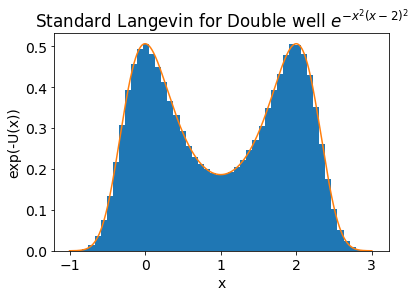

In [15]:
# Use composite trapezoidal rule to compute the normalization constant
x_integration = np.linspace(-10,10,10000)
normalization = np.trapz(np.exp(-U(x_integration)),x_integration)

x_plot = np.linspace(-1,3,1000)
plt.rcParams.update({'font.size': 14})
plt.hist(xsamples,label = "hist",bins=50,normed = True)
plt.plot(x_plot,np.exp(-U(x_plot))/normalization)  # beta = 1
plt.ylabel("exp(-U(x))")
plt.xlabel("x")
plt.title("Standard Langevin for Double well $e^{-x^2(x-2)^2}$")
#plt.legend()
plt.plot()



## Double Well example for ISST with force rescaling

\begin{align}
    \rho(q,p,\beta_R) &= C^{-1}(\beta)\omega(\beta_c)e^{-\frac{1}{2}\beta p^T m^{-1}p - \beta_c U(q)} \\
    &= C^{-1}(\beta)\omega(\beta_c)e^{-\frac{1}{2}\beta p^T m^{-1}p - \beta_c q^2(q-2)^2}
\end{align}

[]

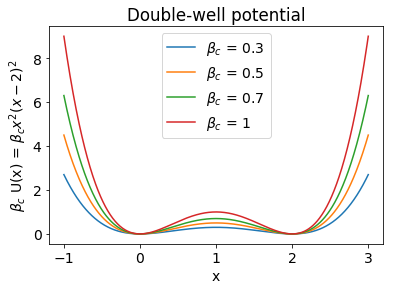

In [16]:
x_plot = np.linspace(-1,3,1000)
plt.rcParams.update({'font.size': 14})
beta_c = [0.3,0.5,0.7,1]  # Tempering parameter
for i in range(4):
    plt.plot(x_plot,beta_c[i]*U(x_plot),label = '$\\beta_c$ = %g' % beta_c[i])  # beta = 1
plt.ylabel("$\\beta_c$ U(x) = $\\beta_c x^2 (x-2)^2$")
plt.xlabel("x")
plt.title("Double-well potential")
plt.legend()
plt.plot()

[]

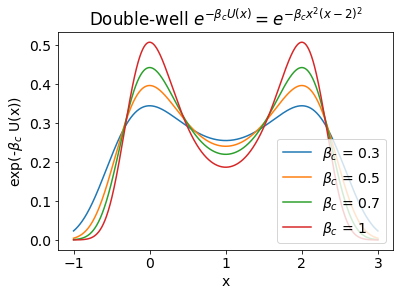

In [17]:
x_plot = np.linspace(-1,3,1000)
x_integration = np.linspace(-10,10,10000)
plt.rcParams.update({'font.size': 14})
beta_c = [0.3,0.5,0.7,1]  # Tempering parameter
for i in range(4):
    normalization = np.trapz(np.exp(-beta_c[i]*U(x_integration)),x_integration)
    plt.plot(x_plot,np.exp(-beta_c[i]*U(x_plot))/normalization,label = '$\\beta_c$ = %g' % beta_c[i])  # beta = 1
plt.ylabel("exp(-$\\beta_c$ U(x))")
plt.xlabel("x")
plt.title("Double-well $e^{-\\beta_c U(x)} = e^{-\\beta_c x^2 (x-2)^2}$")
plt.legend(loc='lower right')
plt.plot()

In [18]:
h = 0.01 # Step size of the discretization
gamma = 1 # Friction parameter
num_steps = 1000000

npr.seed(2)

# Parameters for ISST method
tau = 1  # Indicates how often we update the weights relative to the x and p parameters
M = 5   # Number of temperature values
beta_min = 0.4  #  the tempering parameter beta_c is in the interval [beta_min,beta_max]
beta_max = 1.05  # Target temperature, the tempering parameter beta_c is in the interval [beta_min,beta_max]
betatot = 1  # Physical temperature (is fixed)

# These matrices will be filled with the samples
xsamples = np.zeros(num_steps)
psamples = np.zeros(num_steps)
Obsweights = np.zeros((num_steps,M))
weightedx2 = np.zeros((num_steps,M))

# Initialize values
x = 0.1
p = npr.randn(1) #Create auxiliary momentum variable as sample of a N(0,1) distribution

# Create temperature grid for Gauss-Legendre quadrature 
beta, B = np.polynomial.legendre.leggauss(M)  # beta are the sample points and B are the weights
betasc = 0.5*(beta + 1)*(beta_max - beta_min) + beta_min # rescale so that the sample points are in the interval [beta_min,beta_max]  (because np.polynomial.legendre.leggauss generates points in interval [-1,1])
omega = np.ones(M) # initialize the temperature weights

# # Normalize betasc   # not sure if this is necessary
# norm = np.sum(B*omega)
# betasc = betasc/norm
print("Tempering inverse temperatures",np.round(betasc,3))

# Compute <x^2> using composite trapezoidal rule 
xtest = np.linspace(-100,100,100000)
avgx2usingtrapz = np.zeros(M)
for i in range(M):
    avgx2usingtrapz[i] = np.trapz((xtest**2)*np.exp(-betasc[i]*U(xtest)),xtest)/np.trapz(np.exp(-betasc[i]*U(xtest)),xtest)
    print('using composite trapezoidal rule <x^2> = ', np.round(avgx2usingtrapz[i],4) ,'for beta_c = ', np.round(betasc[i],3))

# Compute initial value of the averaged beta using eq (61) and (58) in ISST paper
z = np.exp(-betasc*U(x))/np.sum(B*omega*np.exp(-betasc*U(x)))
avgbeta = np.sum(betasc*B*omega*np.exp(-betasc*U(x)))/np.sum(B*omega*np.exp(-betasc*U(x)))

print("Starting...")
for steps in range(1,num_steps): 
    # 2nd order 'BAOAB' scheme, eq (57) in ISST paper
    p -= (h/2.0)*(1./betatot)*avgbeta*gradU(x)  
    x += (h/2.0)*p
      
    eta = npr.randn(1)
    p = np.exp(-gamma*h)*p +np.sqrt((1/betatot)*(1-np.exp(-2*gamma*h)))*eta

    x += (h/2.0)*p 
    
    # Update temperature weights and avgbeta to update the force rescaling
    # Use eq (58),(59), (60) and (63) in ISST paper
    z = ((1.0/steps)*np.exp(-betasc*U(x))/np.sum(B*omega*np.exp(-betasc*U(x))))+((steps-1)/steps)*z
    omegastar = (1-(h/tau))*omega+(h/(tau*z))
    omega = omegastar/np.sum(B*omegastar)
    avgbeta = np.sum(betasc*B*omega*np.exp(-betasc*U(x)))/np.sum(B*omega*np.exp(-betasc*U(x)))
        
    p -= (h/2.0)*(1./betatot)*avgbeta*gradU(x)  
    
    # Store the samples
    xsamples[steps] = x
    psamples[steps] = p
    
    # Compute the observable weights following eq. (29) in ISST paper

    weightobs = np.zeros(M)
    for i in range(M):
        integral = 0
        for j in range(M):
            integral += B[j]*omega[j]*np.exp(-(betasc[j] - betasc[i])*U(x))
                         
        weightobs[i] = 1/(integral*z[i])
            
    Obsweights[steps,:] = weightobs
    
    # Compute weighted <x^2>
    weightedx2[steps,:] = weightobs*xsamples[steps]**2
    
    # Print progress
    if steps % 200000 == 0:
        print("currently at step ", steps,"/",num_steps)
        for i in range(M):
            print("<x^2> = ",np.round(np.mean(weightedx2[0:steps,i]),4)," for beta_c = ", np.round(betasc[i],3), ', while using composite trapezoidal rule <x^2> = ', np.round(avgx2usingtrapz[i],4))

print("final step")
for i in range(M):
    print("<x^2> = ",np.round(np.mean(weightedx2[:,i]),4)," for beta_c = ", np.round(betasc[i],3), ', while using composite trapezoidal rule <x^2> = ', np.round(avgx2usingtrapz[i],4))

Tempering inverse temperatures [0.43  0.55  0.725 0.9   1.02 ]
using composite trapezoidal rule <x^2> =  1.9178 for beta_c =  0.43
using composite trapezoidal rule <x^2> =  1.8801 for beta_c =  0.55
using composite trapezoidal rule <x^2> =  1.8504 for beta_c =  0.725
using composite trapezoidal rule <x^2> =  1.8366 for beta_c =  0.9
using composite trapezoidal rule <x^2> =  1.8323 for beta_c =  1.02
Starting...
currently at step  200000 / 1000000
<x^2> =  1.9794  for beta_c =  0.43 , while using composite trapezoidal rule <x^2> =  1.9178
<x^2> =  1.9507  for beta_c =  0.55 , while using composite trapezoidal rule <x^2> =  1.8801
<x^2> =  1.9273  for beta_c =  0.725 , while using composite trapezoidal rule <x^2> =  1.8504
<x^2> =  1.9172  for beta_c =  0.9 , while using composite trapezoidal rule <x^2> =  1.8366
<x^2> =  1.9149  for beta_c =  1.02 , while using composite trapezoidal rule <x^2> =  1.8323
currently at step  400000 / 1000000
<x^2> =  1.8942  for beta_c =  0.43 , while usin

/Users/tiffany/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[]

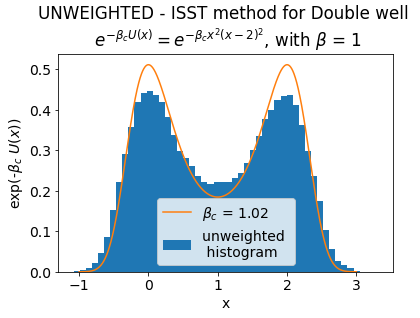

In [19]:
# Use composite trapezoidal rule to compute the normalization constant
x_integration = np.linspace(-10,10,10000)
normalization = np.trapz(np.exp(-betasc[M-1]*U(x_integration)),x_integration)

x_plot = np.linspace(-1,3,1000)
plt.rcParams.update({'font.size': 14})
plt.hist(xsamples,bins=50,normed = True, label = "unweighted \n histogram")
plt.plot(x_plot,np.exp(-betasc[M-1]*U(x_plot))/normalization,label = '$\\beta_c$ = %g' % np.round(betasc[M-1],3))  # beta = 1
plt.ylabel('exp(-$\\beta_c \ U(x)$)')
plt.xlabel("x")
plt.title("UNWEIGHTED - ISST method for Double well \n $e^{-\\beta_c U(x)} = e^{-\\beta_c x^2(x-2)^2}$, with $\\beta$ = 1")
plt.legend()
plt.plot()

/Users/tiffany/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


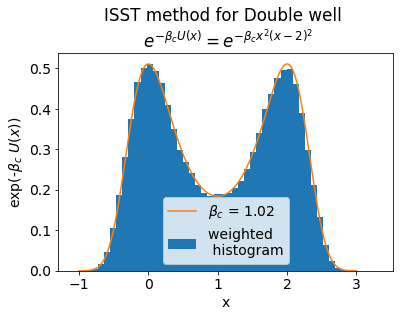

In [21]:
# Use composite trapezoidal rule to compute the normalization constant
x_integration = np.linspace(-10,10,10000)
normalization = np.trapz(np.exp(-betasc[M-1]*U(x_integration)),x_integration)

x_plot = np.linspace(-1,3,1000)
plt.rcParams.update({'font.size': 14})
plt.hist(xsamples,bins=50,normed = True, weights = Obsweights[:,M-1], label = "weighted \n histogram")
plt.plot(x_plot,np.exp(-betasc[M-1]*U(x_plot))/normalization,label = '$\\beta_c$ = %g' % np.round(betasc[M-1],3))  # beta = 1
plt.ylabel('exp(-$\\beta_c \ U(x)$)')
plt.xlabel("x")
plt.title("ISST method for Double well \n $e^{-\\beta_c U(x)} = e^{-\\beta_c x^2(x-2)^2}$")
plt.legend()
plt.plot()
plt.savefig("ISST_doublewell.pdf")